In [2]:
%matplotlib notebook
from numpy import *
import numpy as np
from numpy.linalg import *
from scipy.sparse.linalg import *
from scipy.sparse import *


In [296]:
##Test mass conservation simpler methods
##Explicit Euler

from scipy.sparse.linalg import inv

def lhs_explicit(M,N,alpha):
    A = np.eye(M+1)
    A[0,0]=1
    A[0,1]=-1
    A[-1,-1]=1
    A[-1,-2]=-1

    return A


def rhs_explicit(M,N,alpha):
    a = ones(M+1)
    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
    Id = eye(M+1)
    
    B = Id +alpha*D
    B[0,0]=0
    B[0,1]=0
    B[-1,-1]=0
    B[-1,-2]=0
    
    return B



def mass(x):
    return sum(x[1:-1])
   
epsilon=0.2
M = 10
N =100

deltax=1/(M+1)
deltat=1/(N+1)
alpha=epsilon**2*deltat/2/deltax**2
assert(abs(alpha)<1)

A=lhs_explicit(M,N,alpha)
B=rhs_explicit(M,N,alpha)

v = np.random.rand(M+1,1)
v[0]=v[1]
v[-1]=v[-2]


sol = spsolve(A,B@v)

abs(mass(v)-mass(sol))

0.0

In [288]:
##Test mass conservation simpler methods
##Implicit Euler in space

from scipy.sparse.linalg import inv
from scipy.sparse import coo_matrix, vstack

def lhs_implicit(M,N,alpha):
    a = ones(M+1)

    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
    
    Id = eye(M+1)
    
    A = Id -alpha*D
    A[0,0]=1
    A[0,1]=-1
    A[-1,-1]=1
    A[-1,-2]=-1
    return A


#def rhs_implicit(M,N,alpha):
#    a=ones(M)
#
#    return spdiags([a],(1,),M-1,M+1)

def rhs_implicit(M,N,alpha):
    a = ones(M+1)
    a[0]=0
    a[-1]=0

    return spdiags(a,(0,),M+1,M+1)
    
def mass(x):
    return sum(x[1:-1])
   
epsilon=0.2
M = 10
N =100

deltax=1/(M+1)
deltat=1/(N+1)
alpha=epsilon**2*deltat/deltax**2
assert(abs(alpha)<1)

A=lhs_implicit(M,N,alpha)
B=rhs_implicit(M,N,alpha)

v = np.random.rand(M+1,1)
v[0]=v[1]
v[-1]=v[-2]


sol = spsolve(A,B@v)



print(abs(mass(v)-mass(sol)))

4.440892098500626e-16


In [293]:
##Debug test Crank-Nicolson
from scipy.sparse.linalg import inv


def lhs_simple(M,N,alpha):

    return lhs_implicit(M,N,alpha)


def rhs_simple(M,N,alpha):

    
    return 1/2*(rhs_implicit(M,N,alpha)+rhs_explicit(M,N,alpha))



def mass(x):
    return sum(x[1:-1])
   
epsilon=0.2
M = 10
N =100

deltax=1/(M+1)
deltat=1/(N+1)
alpha=epsilon**2*deltat/2/deltax**2
assert(abs(alpha)<1)

A=lhs_simple(M,N,alpha)
B=rhs_simple(M,N,alpha)

v = np.random.rand(M+1,1)
v[0]=v[1]
v[-1]=v[-2]


sol = spsolve(A,B@v)

abs(mass(v)-mass(sol))

0.0

In [294]:
x = linspace(0,1,M+1)
dx=1/(M+1)
dt=1/(N+1)
eps = 0.01
cfl = dx/(2*dt) - eps/dx
factg = 10
rho_ini = transpose([exp (-factg*(x-5)**2) ])
#rho_ini = rho_ini[1:M+1]
rho_ini = rho_ini / (dx * sum(rho_ini))
rho_ini=rho_ini.reshape(M+1)
rho_ini[0]=rho_ini[1]
rho_ini[-1]=rho_ini[-2]
V = transpose([exp (-factg*(x-2)**2) ]) + transpose([exp (-factg*(x-8)**2) ])
V = V[1:M+1]
V = 0.1 * (max(V)-V) / ( dx*sum(max(V)-V) )

alpha=epsilon**2*deltat/deltax**2
assert(abs(alpha)<1)

def Crank_Nicolson(M, N, dx, dt, eps, U0):
    r = (eps**2 * dt) / (2 * dx**2)
    A = lhs_simple(M,N,alpha)
    B = rhs_simple(M,N,alpha)
    U = zeros([M+1, N])
    U[:,0] = U0
    for n in range(N-1):
        U[:,n+1] = spsolve(A, B@U0)

        U0 = U[:,n+1]

    return U

<IPython.core.display.Javascript object>


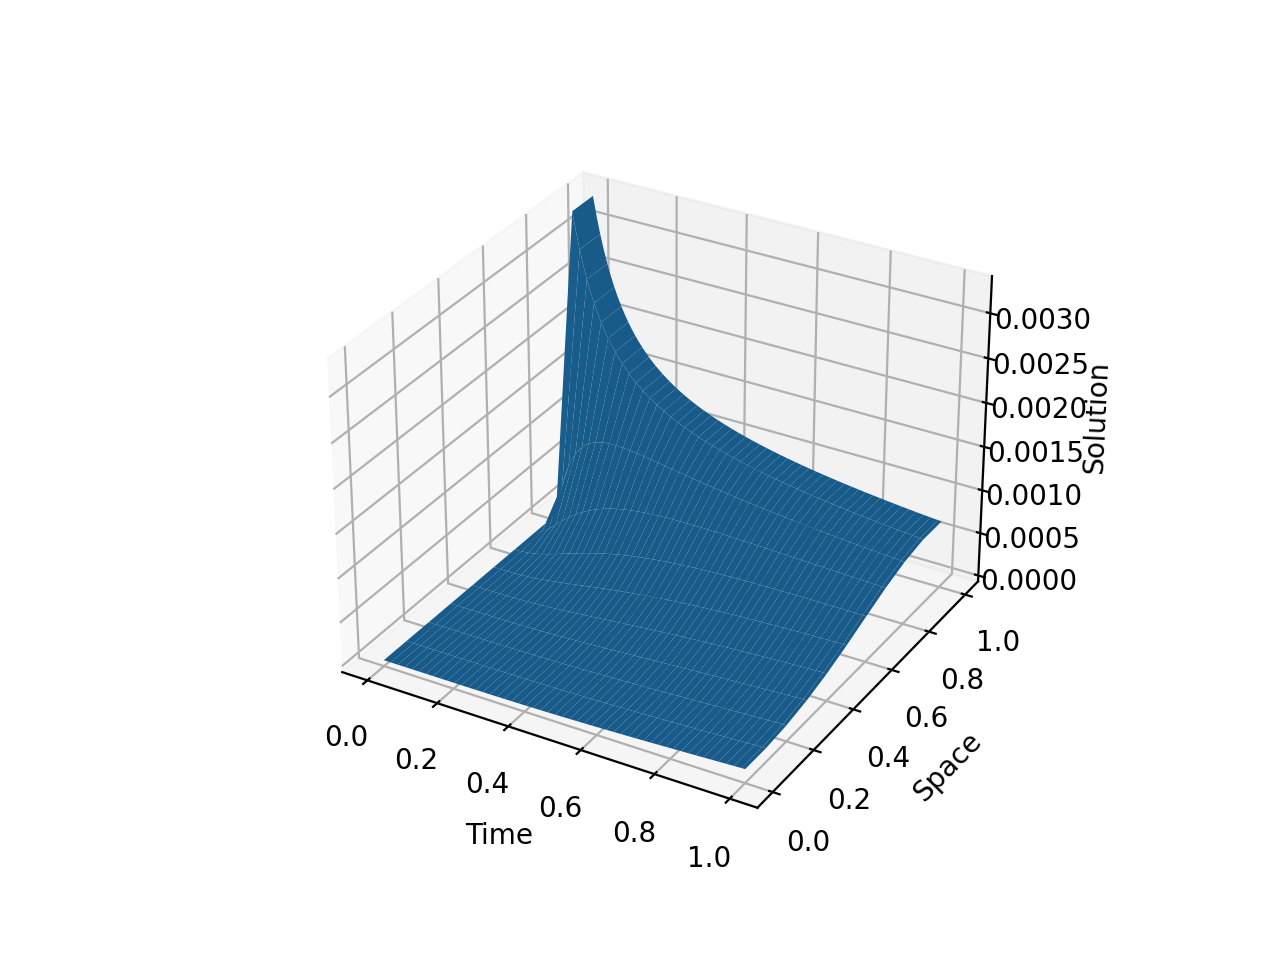

Text(0.5, 0, 'Solution')

In [295]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
t = np.linspace(0,1,N)

sol=Crank_Nicolson(M, N, dx, dt, eps, rho_ini)

 
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

X,Y=meshgrid(t,x)
#print(X.shape,Y.shape,sol.reshape(X.shape).shape)

ax.plot_surface(X,Y,sol.reshape(X.shape))

ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('Solution')

In [366]:
from sympy.abc import *
from sympy import *
#x=Symbol("x",real=True)
x = Symbol("x")
f= a*x**2+b*x+c

a = symbols("a0:3")
f = symbols("f0:3")
x0 = Symbol("x0")

vals = [0,h,2*h]

pol = sum([a[i]*x**i for i in range(len(a))])
p=pol.subs(solve([f[i]-pol.subs(x,vals[i]) for i in range(len(a))],a))
p.diff(x).subs(x,0)

(-3*f0 + 4*f1 - f2)/(2*h)

In [371]:
x = Symbol("x")
a = symbols("a0:3")
f = symbols("f0:3")
x0 = Symbol("x0")

vals = [0,-h,-2*h]

pol = sum([a[i]*x**i for i in range(len(a))])
p=pol.subs(solve([f[i]-pol.subs(x,vals[i]) for i in range(len(a))],a))
p.diff(x).subs(x,0)

(3*f0 - 4*f1 + f2)/(2*h)

In [435]:
n=4

x,x0 = symbols("x,x0")
a = symbols(f"a0:{n}")
f = symbols(f"f0:{n}")
x0 = Symbol("x0")

vals = [i*h for i in range(n)]

pol = sum([a[i]*x**i for i in range(len(a))])
p=pol.subs(solve([f[i]-pol.subs(x,vals[i]) for i in range(len(a))],a))
p.diff(x).subs(x,0)

(-11*f0 + 18*f1 - 9*f2 + 2*f3)/(6*h)

**Test with new bodundary conditions**

In [386]:
#Test

def lhs_simple(M,N,alpha):
    a = ones(M+1)

    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
    
    Id = eye(M+1)
    
    A = Id -alpha*D
    A[0,0]=3
    A[0,1]=-4
    A[0,2]=1
    A[-1,-3]=-1
    A[-1,-2]=4
    A[-1,-1]=3
    
    return A


def rhs_simple(M,N,alpha):
    a = ones(M+1)
    a[0]=0
    a[-1]=0

    A= spdiags(a,(0,),M+1,M+1)

    a = ones(M+1)
    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
    Id = eye(M+1)
    
    B = Id +alpha*D
    B[0,0]=0
    B[0,1]=0
    B[-1,-1]=0
    B[-1,-2]=0
    
    
    return 1/2*(A+B)

In [433]:
import numpy as np
from numpy import *
#Discretisation
L = 1
eps=0.01
M = 10
N =int(1e6)
x = np.linspace(0,L,M+1)
dx = x[2]- x[1]
T = 1
#N = int(1e3)
t = np.linspace(0,T,N)
dt = t[1] -t[0]



#Parameters' model
eps = 10
cfl = dx/(2*dt) - eps/dx
factg = 10
rho_ini = transpose([exp (-factg*(x-5)**2) ])
#rho_ini = rho_ini[1:M+1]
rho_ini = rho_ini / (dx * sum(rho_ini))
rho_ini=rho_ini.reshape(M+1)
rho_ini[0]=rho_ini[1]
rho_ini[-1]=rho_ini[-2]
V = transpose([exp (-factg*(x-2)**2) ]) + transpose([exp (-factg*(x-8)**2) ])
V = V[1:M+1]
V = 0.1 * (max(V)-V) / ( dx*sum(max(V)-V) )

#def Crank_Nicolson(M, N, dx, dt, eps, U0):
#    r = (eps**2 * dt) / (2 * dx**2)
#    a = ones(M+1)
#    A = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
#    Id = eye(M+1)
#    J = Id - r*A
#    J[0,0] = 1
#    J[0,1] = -1
#    J[M,M-1] = 1
#    J[M,M] = -1
#    B = r*A + Id
#    U = zeros([M+1, N])
#    U[:,0] = U0
#    for n in range(N-1):
#        U0[0] = 0
#        U0[-1] = 0
#        U[:,n+1] = spsolve(J, B@U0)
#        U0 = U[:,n+1]
#    return U

def Crank_Nicolson(M, N, dx, dt, eps, U0):
    alpha=eps**2*dt/dx**2
    print(alpha)
    assert(abs(alpha)<1)
    
    A = lhs_implicit(M,N,alpha)
    B = rhs_implicit(M,N,alpha)
    U = zeros([M+1, N])
    U[:,0] = U0
    for n in range(N-1):
        U[:,n+1] = spsolve(A, B@U0)

        U0 = U[:,n+1]

    return U

0.010000010000009997


<IPython.core.display.Javascript object>


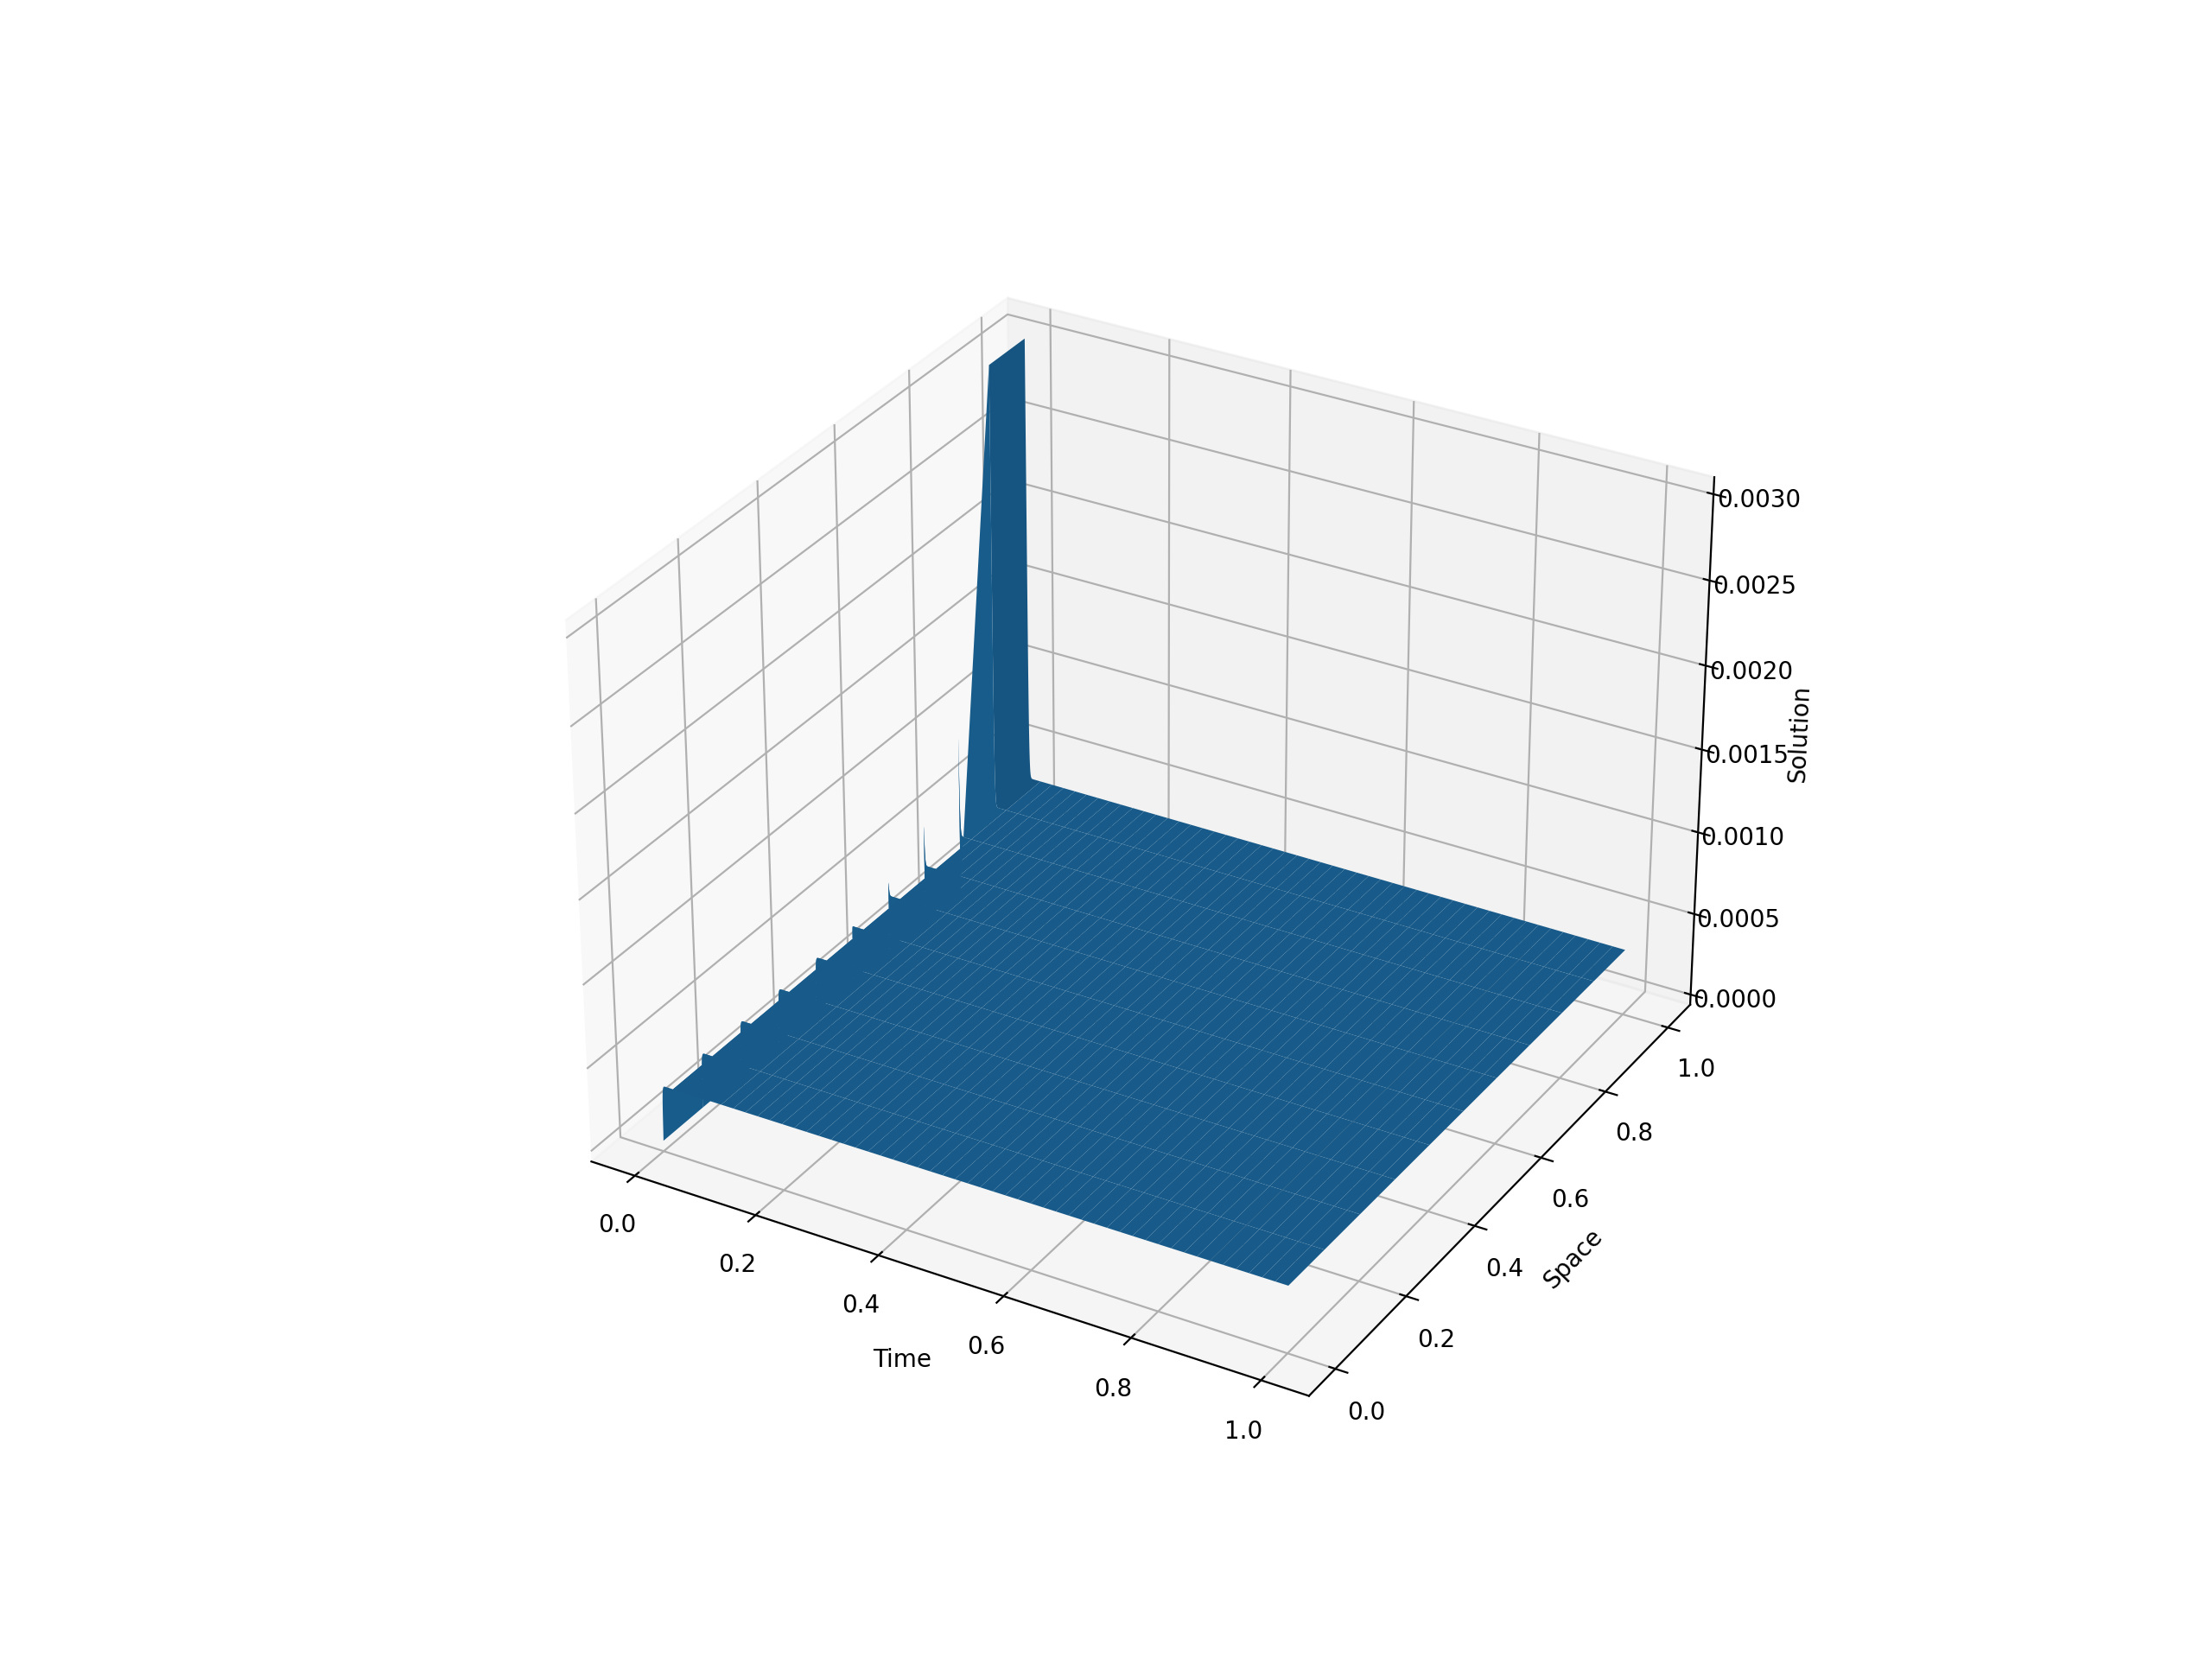

Text(0.5, 0, 'Solution')

In [434]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

sol=Crank_Nicolson(M, N, dx, dt, eps, rho_ini)

 
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

X,Y=meshgrid(t,x)

ax.plot_surface(X,Y,sol.reshape(X.shape))

ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('Solution')

In [424]:
dt

1.000001000001e-06

In [425]:
alpha=eps**2*dt/dx**2

In [426]:
alpha

0.010000010000009997

In [414]:
deltax

0.09090909090909091

In [417]:
t[1]-t[0]

1.000001000001e-06

In [468]:

eps=0.2
M = 10
N =100

deltax=1/(M+1)
deltat=1/(N+1)
alpha=eps**2*deltat/2/deltax**2

#Method implementation

def mass(x):
    return sum(x[1:-1])

###Explicit
##
##def lhs_explicit(M,N,alpha):
##    A = np.eye(M+1)
##    A[0,0]=1
##    A[0,1]=-1
##    A[-1,-1]=1
##    A[-1,-2]=-1
##
##    return A
##
##
##def rhs_explicit(M,N,alpha):
##    a = ones(M+1)
##    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
##    Id = eye(M+1)
##    
##    B = Id +alpha*D
##    B[0,0]=0
##    B[0,1]=0
##    B[-1,-1]=0
##    B[-1,-2]=0
##    
##    return B
##
###Implicit
##def lhs_implicit(M,N,alpha):
##    a = ones(M+1)
##
##    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
##    
##    Id = eye(M+1)
##    
##    A = Id -alpha*D
##    A[0,0]=1
##    A[0,1]=-1
##    A[-1,-1]=1
##    A[-1,-2]=-1
##    return A
##
##def rhs_implicit(M,N,alpha):
##    a = ones(M+1)
##    a[0]=0
##    a[-1]=0
##
##    return spdiags(a,(0,),M+1,M+1)

#Crank-Nicolson= lhs_implicit=1/2(rhs_implicit+rhs_explicit)


def lhs_simple(M,N,alpha):
    a = ones(M+1)

    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
    
    Id = eye(M+1)
    
    A = Id -alpha*D
    #Order one boundary conditions
    A[0,0]=1
    A[0,1]=-1
    A[-1,-1]=1
    A[-1,-2]=-1
    
    ##Order two:
    #A[0,0]=3
    #A[0,1]=-4
    #A[0,2]=1
    #A[-1,-3]=-1
    #A[-1,-2]=4
    #A[-1,-1]=-3
    
    return A


def rhs_simple(M,N,alpha):
    a = ones(M+1)
    a[0]=0
    a[-1]=0

    A= spdiags(a,(0,),M+1,M+1)

    a = ones(M+1)
    D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
    Id = eye(M+1)
    
    B = Id +alpha*D
    B[0,0]=0
    B[0,1]=0
    B[-1,-1]=0
    B[-1,-2]=0
    
    return 1/2*(A+B)

def half_v(i,n):
    #Option 1
    #return v[i,n]
    
    #Option 2
    return 1/2*(v[i-1,n]+v[i,n])


def rhs_godunov(M,N,U0,v,n):
    def index(j):
        if v[j,n]<0:
            return j+1
        else:
            return j
    G = zeros(M+1)
    for i in range(1,M):
        G[i]= U0[index(i)]*half_v(i,n)-U0[index(i)]

    return G


In [471]:
from numpy.linalg import inv
methodMatrix = inv(lhs_simple(M,N,alpha))@rhs_simple(M,N,alpha)

test = np.zeros([M+1,1])
test[2]=1

methodMatrix@test

matrix([[3.35299884e-02],
        [3.35299884e-02],
        [9.32922065e-01],
        [3.27804816e-02],
        [7.49908178e-04],
        [1.71554000e-05],
        [3.92458383e-07],
        [8.97813998e-09],
        [2.05392381e-10],
        [4.80612610e-12],
        [4.80612610e-12]])

In [472]:
mass(test),mass(methodMatrix@test)

(1.0, 0.9999999999999999)

In [443]:
a = ones(M+1)
D = spdiags([a,-2*a,a], (-1,0,1), M+1, M+1)
    
Id = eye(M+1)-alpha*D

TypeError: unsupported operand type(s) for *: 'dia_matrix' and 'Mul'

In [444]:
alpha

0.599009900990099*epsilon**2